# Turtle Recall Tutorial

Welcome to the tutorial for the **Turtle Recall: Conservation Challenge [Zindi competition](https://zindi.africa/competitions/turtle-recall-conservation-challenge)**!

In this notebook, we'll be taking you through an explanation of the challenge, dataset, and an example approach for building a model that can recognise faces of individual turtles.

<p align="center">
  <img src="https://storage.googleapis.com/dm-turtle-recall/tutorial_images/shelfie.jpg" width="512"/>
</p>


Table of contents:

1. [Introduction](#Introduction)
2. [Dataset overview](#Dataset)
3. [Data exploration](#Exploration)
4. [Approaching the modelling problem](#Approach)
5. [A quick introduction to JAX and Haiku](#JAX)
6. [Fine-tuning a ResNet model using JAX and Haiku](#Model)
7. [Submitting our predictions](#Submit)
8. [Suggestions for improving the model](#Suggestions)
9. [License and Disclaimer](#Legal)



<a name="Introduction"></a>
## 1. Introduction

The aim of this competition is to build a machine learning model to identify individual sea turtles. For each image presented, the model should output the turtle's unique ID or, if the image corresponds to a new turtle (not present in the database), identify it as a new individual.

<a name="Dataset"></a>
## 2. Dataset overview

The dataset provided with this challenge consists of the following files:
- `train.csv` containing 3 columns:
  - `image_id`: image identifier, mapping to `.JPG` image files located in the `IMAGES` subfolder.
  - `image_location`: this indicates whether the image is the left, right or top view of the turtle's face.
  - `turtle_id`: unique turtle identifier (what your model will be trained to predict given the image)
- `extra_images.csv` of turtle images containing 2 columns, `image_id` and `turtle_id`.
- `test.csv` contains test set image annotation with two columns `image_id` and `image_location`
  - Note that one possible outcome class is `new_turtle`, meaning that you may be asked to classify turtles that were not previously observed in the training set.
- `sample_submission.csv`: example submission file showing the 2 column format for submissions:
  - The first column is an `image_id`
  - The second column is a list of 5 `turtle_id` entries showing your top 5 predictions for the identity of the turtle shown in the image.

To get a sense of the data, here are a few examples from the training dataset:

<p align="center">
  <img src="https://storage.googleapis.com/dm-turtle-recall/tutorial_images/training_examples.png" width="600"/>
</p>

You can maybe already see some of the potential challenges inherent in this dataset!
- **Face positioning**. Turtle face pictures can be taken from 3 main angles, and even within a position category like "left", head position can vary.
- **Image dimensions**. Image dimensions and aspect ratios can vary, e.g. the "top" image is in tall format whereas the other three are in wide format.
- **Image quality**. The blurriness vs. sharpness of the images can vary

Looking through other images, you'll find other sources of diversity:
- Differences in backgrounds and lighting conditions
- Extraneous objects in the image such as hands, people in the background, and tags (not related to `turtle_id`)
- Turtles can have varying amounts of sand on their head

Here is a collage of some raw, unreshaped image samples from the training dataset:

<p align="center">
  <img src="https://storage.googleapis.com/dm-turtle-recall/tutorial_images/training_image_collage.png" width="800"/>
</p>

The challenge is to be able to recognise turtle faces despite the noise and confounding factors in the images!


<a name="Exploration"></a>
## 3. Data exploration

Next, we can load the train and test datasets and start to make some exploratory plots.



We download the images from a Google Cloud storage bucket (could take some time):

In [1]:
import os

SOURCE_URL = 'https://storage.googleapis.com/dm-turtle-recall/images.tar'
IMAGE_DIR = '../images'
TAR_PATH = os.path.join(IMAGE_DIR, os.path.basename(SOURCE_URL))
EXPECTED_IMAGE_COUNT = 13891

%sx mkdir --parents "{IMAGE_DIR}"
if len(os.listdir(IMAGE_DIR)) != EXPECTED_IMAGE_COUNT:
  %sx wget --no-check-certificate -O "{TAR_PATH}" "{SOURCE_URL}"
  %sx tar --extract --file="{TAR_PATH}" --directory="{IMAGE_DIR}"
  %sx rm "{TAR_PATH}"

print(f'The total number of images is: {len(os.listdir(IMAGE_DIR))}')

The total number of images is: 13891


Read in the train, test, and sample submission CSV files as pandas dataframes:

In [2]:
import pandas as pd
import requests
import io
import urllib.parse

BASE_URL = 'https://storage.googleapis.com/dm-turtle-recall/'


def read_csv_from_web(file_name):
  url = urllib.parse.urljoin(BASE_URL, file_name)
  content = requests.get(url).content
  return pd.read_csv(io.StringIO(content.decode('utf-8')))


# Read in csv files.
train = read_csv_from_web('train.csv')
test = read_csv_from_web('test.csv')
sample_submission = read_csv_from_web('sample_submission.csv')

# Convert image_location strings to lowercase.
for df in [train, test]:
  df.image_location = df.image_location.apply(lambda x: x.lower())
  assert set(df.image_location.unique()) == set(['left', 'right', 'top'])

Check out our dataframes and print their shapes:

In [3]:
train.head()

,image_id,image_location,turtle_id
0,ID_2RK4WLN8,top,t_id_VP2NW7aV
1,ID_VVW0QXLX,left,t_id_qZ0iZYsC
2,ID_RVATH2HZ,right,t_id_3b65X5Lw
3,ID_2GB90GPS,left,t_id_YjXYTCGC
4,ID_LM6S0B1M,top,t_id_d6aYXtor


In [4]:
test.head()

,image_id,image_location
0,ID_6NEDKOYZ,top
1,ID_57QZ4S9N,left
2,ID_OCGGJS5X,left
3,ID_R2993S3S,top
4,ID_2E011NB0,left


In [5]:
sample_submission.head()

,image_id,prediction1,prediction2,prediction3,prediction4,prediction5
0,ID_6NEDKOYZ,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
1,ID_57QZ4S9N,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
2,ID_OCGGJS5X,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
3,ID_R2993S3S,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor
4,ID_2E011NB0,new_turtle,t_id_d6aYXtor,t_id_qZ0iZYsC,new_turtle,t_id_d6aYXtor


In [6]:
train.shape, test.shape, sample_submission.shape

((2145, 3), (490, 2), (490, 6))

How many unique turtles are in the training set?

In [7]:
print(f"There are {train.turtle_id.nunique()} unique turtles in the train set.")

There are 100 unique turtles in the train set.


How many images are there for each individual turtle in the training set?

The mean number of training images per turtle is 21.45, and the median is 16.


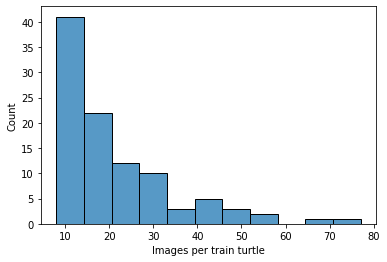

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_images_per_turtle = pd.value_counts(train['turtle_id'])
print('The mean number of training images per turtle is '
      f'{round(np.mean(train_images_per_turtle), 2)}, '
      f'and the median is {int(np.median(train_images_per_turtle))}.')
sns.histplot(train_images_per_turtle)
plt.xlabel('Images per train turtle')
plt.show()

We can plot the number of images per `turtle_id`:


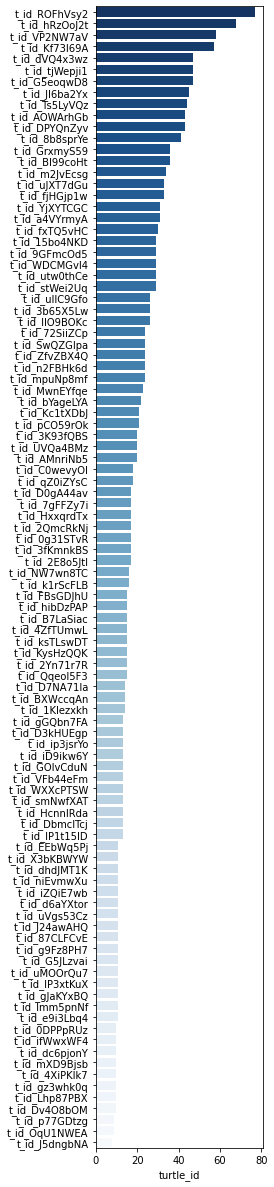

In [9]:
images_per_turtle = pd.value_counts(train['turtle_id'])
plt.figure(figsize=(3, 21))
sns.barplot(x=images_per_turtle, y=images_per_turtle.index,
            palette='Blues_r', orient='horizontal')
plt.show()

Some observations from these plots:
- This dataset is small, with not many images per class.
- This dataset is characterised by class imbalance, with some turtles having many more training images available than others.


<a name="Approach"></a>
## 4. Approaching the modelling problem

Since we want to match images to labels (classes), we are dealing with an **image classification** problem. Image classification is generally most successfully approached using deep **convolutional neural networks** (CNNs).

### 4.1 Convolutional neural networks

At the highest level, CNNs take images as inputs and return probabilities that the image belongs to each of the possible classes.

In slightly more detail, CNNs hierarchically extract features from images using convolutional layers, which are usually followed by pooling layers that summarise the information in the extracted feature maps:
- Lower CNN layers capture low-level image features (edges, blobs)
- Layers deeper in the CNN capture higher-level features and objects (scale patterns, turtle eyes)
- Fully connected layers can then consolidate these extracted patterns and objects

<p align="center">
  <img src="https://storage.googleapis.com/dm-turtle-recall/tutorial_images/cnn.png" width="1100"/>
</p>

We won't go into a detailed explanation of CNNs here; if you'd like to learn more about their inner workings, we recommend [CS231n: Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/).

### 4.2 Transfer learning for image classification

To approach this turtle face classification problem, we could specify a CNN architecture, initialise it, and proceed to train its parameters from scratch.

An alternative approach, which is very popular in the computer vision (image processing) world, is called **transfer learning**:
- Instead of training your model on your task from scratch, you first identify a model that has been **pre-trained** on some other image task
- You can then adapt it (**"fine-tune"** it) to your specific task

This is a popular approach because it often gets you two advantages:
- **Improved performance**. The pre-training does a lot of the heavy lifting of learning to understand images. The most popular pre-trained models were trained on huge datasets for a long period of time, and you can simply piggy back on what they've learned.
  - The features that these models learn are often reusable for many image-related tasks.
  - This is because lower level visual features such as edges, colour blobs, simple composite shapes etc. are pervasive regardless of the specifics of the image task.
- **Lower data and computational requirements**. Using a pre-trained model often means you don't need as much training data, time, or compute to reach a certain level of performance.

There are plenty of pre-trained computer vision models available, the most popular probably being VGG, ResNet, EfficientNet, etc.

Here, we will make use of a pre-trained ResNetX model made available via the **Haiku** library (a tool for building neural networks in **JAX**).


<p align="center">
  <img src="https://storage.googleapis.com/dm-turtle-recall/tutorial_images/jax.png" width="900"/>
</p>

The rest of this tutorial will implement an image classification neural network using JAX, which is a language or framework for numerical computation and deep learning that is frequently used by researchers and engineers at DeepMind. Since JAX is still less common than other tools such as Keras, Tensorflow, and PyTorch, the next section contains a quick introduction to some of the core features of JAX and Haiku.

**Note**: It is not at all necessary to use JAX for this challenge, but we thought this might be a nice opportunity to introduce more people to this powerful and elegant way of writing machine learning code.

If you are already familiar with JAX, feel free to skip the next section :)

<a name="JAX"></a>
## 5. A very quick introduction to JAX and Haiku

JAX is an open-source Python library that facilitates high-performance machine learning. JAX is sometimes called **"accelerated NumPy"**, in that JAX code is very similar to NumPy code (with many direct equivalents to NumPy commands) but offers various speedups, efficiency improvements, and built-in GPU/TPU support compared to NumPy.

### 5.1 JAX overview

JAX is based on the following principles:
- **Just-In-Time (JIT) compilation**. JAX can substantially speed up your code by using a special compiler called XLA (accelerated linear algebra) under the hood that fuses operations in your code, enabling it to run faster and more efficiently.
- **Automatic differentiation**
- **Vectorisation**
- **Parallelism**


Here is a simple (non-ML) example of JAX usage:

You should consider upgrading via the '/Users/tolga/.pyenv/versions/3.9.4/bin/python3.9 -m pip install --upgrade pip' command.


/Users/tolga/.pyenv/versions/3.9.4/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


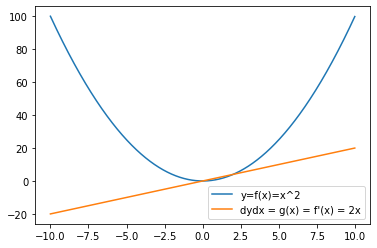

In [10]:
!pip install jaxlib
import jax
import jax.numpy as jnp
try:
  import haiku as hk
except ModuleNotFoundError:
  !pip install dm-haiku
  import haiku as hk

# Define a function.
def f(x):
  return x ** 2

# Wrap function in `jax.grad` to get the gradient.
g = jax.vmap(jax.grad(f))

# Visualize function and derivative for x in [-10, 10].
x = jnp.arange(-10, 10, 0.01)
y = f(x)
dydx = g(x)
plt.plot(x, y)
plt.plot(x, dydx)
plt.legend(["y=f(x)=x^2", "dydx = g(x) = f'(x) = 2x"])
plt.show()

We can greatly speed up repeated calculations by using `jax.jit` for Just-In-Time compilation:

In [11]:
key = jax.random.PRNGKey(1)
key, subkey1, subkey2 = jax.random.split(key, num=3)
a = jax.random.uniform(subkey1, shape=(128, 1000, 1000))
b = jax.random.uniform(subkey2, shape=(128, 1000, 256))

# Define a function.
def f(a, b):
  a = jax.nn.softmax(a, axis=-1)
  return jnp.einsum('ijk,ikl->ijl', a, b)

# Simply wrap the function in `jax.jit` to Just-In-Time compile it at runtime.
g = jax.jit(f)

print('Without jit.')
%time _ = f(a, b)

print('\nWith jit (the first time it runs will be slower since the function is '
      'being compiled.)')
%time _ = g(a, b)

print('\nSubsequent runs with jit will be much faster.')
%time _ = g(a, b)

Without jit.
CPU times: user 1.85 s, sys: 328 ms, total: 2.18 s
Wall time: 595 ms

With jit (the first time it runs will be slower since the function is being compiled.)
CPU times: user 1.77 s, sys: 257 ms, total: 2.03 s
Wall time: 522 ms

Subsequent runs with jit will be much faster.
CPU times: user 1.73 s, sys: 212 ms, total: 1.94 s
Wall time: 465 ms


### 5.2 Haiku overview

The JAX library ecosystem is large and constantly growing, with many new libraries being built using JAX as the backbone. One of the most popular libraries is **Haiku**, which is a neural network library for JAX.

Neural network architectures are specified in the familiar layer-wise manner:

In [12]:
def predict(inputs):
  mlp = hk.Sequential([
      hk.Linear(1024), jax.nn.relu,
      hk.Linear(1024), jax.nn.relu,
      hk.Linear(10), jax.nn.log_softmax,
  ])
  return mlp(inputs)

The main difference/trick of using JAX/Haiku for neural network code is that Haiku models must be defined within a transform. Haiku functions operate only on 'pure' functions whose output is fully determined by the arguments you pass in. For a neural network, the output not only depends on the input, but also the model parameters (for example, on the weights) which are normally implicit. Haiku provides a transformation function that turns functions into a pair of pure functions: one for initializing the parameters (`init`) and one for applying the function to an input given a set of parameters and an RNG key (`apply`).

In [13]:
net = hk.transform(predict)

The init method has to be applied to initialize the parameters of the network and return them. The init method takes a random `jax.random.PRNGKey` value and a sample input to inform the shape of the inputs:

In [14]:
rng = jax.random.PRNGKey(0)
inputs = jax.random.uniform(rng, shape=(16, 1024), dtype=jnp.float32)
params = net.init(rng, inputs)

After that, we are ready to apply the forward functions to some inputs:

In [15]:
preds = net.apply(params, None, inputs)

Don't worry if these JAX and Haiku concepts seem a bit abstract at the moment - you will see these principles in action in the next section, when we fine-tune a pre-trained convolutional network on the turtle face dataset!

<a name="Model"></a>
## 6. Fine-tuning a ResNet model using JAX and Haiku

Time to get started with training our turtle facial recognition model!

First, let's install and import some key libraries:


In [16]:
import jax
import jax.numpy as jnp  # JAX version of numpy with a very similar API.
try:
  import haiku as hk
except ModuleNotFoundError:
  !pip install dm-haiku
  import haiku as hk
try:
  import optax
except ModuleNotFoundError:
  !pip install optax
  import optax
try:
  import immutabledict
except ModuleNotFoundError:
  !pip install immutabledict
  import immutabledict
import functools
from PIL import Image  # Image utilities.
import tqdm

Create three mappings and get the paths to the training set image files.
1. `labels` : turtle ID --> unique integer labels
1. `label_lookup` : unique integer labels --> turtle ID
1. `image_to_turtle` :  image IDs to turtle IDs (training set only).


In [17]:
turtle_ids = sorted(np.unique(train.turtle_id)) + ['new_turtle']
labels = dict(zip(turtle_ids, np.arange(len(turtle_ids))))
label_lookup = {v: k for k, v in labels.items()}
num_classes = len(labels)
image_to_turtle = dict(zip(train.image_id, train.turtle_id))

image_files = [os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)
              if f.split('.')[0] in train.image_id.values]

image_ids = [os.path.basename(f).split('.')[0] for f in image_files]
image_turtle_ids = [image_to_turtle[id] for id in image_ids]

Load the training images into memory - takes a little while!

*   Crops each image around the centre and resizes to `(224, 224)`


In [18]:
def crop_and_resize(pil_img):
  """Crops square from center of image and resizes to (224, 224)."""
  w, h = pil_img.size
  crop_size = min(w, h)
  crop = pil_img.crop(((w - crop_size) // 2, (h - crop_size) // 2,
                       (w + crop_size) // 2, (h + crop_size) // 2))
  return crop.resize((224, 224))


tqdm.tqdm._instances.clear()
loaded_images = [crop_and_resize(Image.open(f)) for f in tqdm.tqdm(image_files)]

100%|███████████████████████████████████████| 2145/2145 [00:43<00:00, 48.80it/s]


Define a function to get a random batch of data from the training images:


*   Randomly select `batch_size` elements from the available images
*   Get the labels for the selected images
*   Optionally rebalance the dataset so that every label is sampled uniformly


Returns the batch of images of shape `(batch_size, 224, 224, 3)` and the integer labels of shape `(batch_size)`



In [19]:
probability_per_label = {
    label: 1 / label_count / len(train_images_per_turtle)
    for label, label_count in train_images_per_turtle.items()
}

probabilities = [
    probability_per_label[image_turtle_id]
    for image_turtle_id in image_turtle_ids
]
assert np.isclose(1., np.sum(probabilities))


def get_batch(batch_size, rebalance=False):
  if rebalance:
    probs = probabilities
  else:
    probs = None
  batch_image_idxs = np.random.choice(
      len(image_files), size=batch_size, replace=False, p=probs)
  input_images = [loaded_images[idx] for idx in batch_image_idxs]
  image_labels = [labels[image_turtle_ids[idx]] for idx in batch_image_idxs]
  return (jnp.stack([
      jnp.asarray(im, dtype=jnp.float32) / 255. for im in input_images
  ]), jnp.stack(image_labels).astype(jnp.int32))

We can visualise what a batch of images looks like:

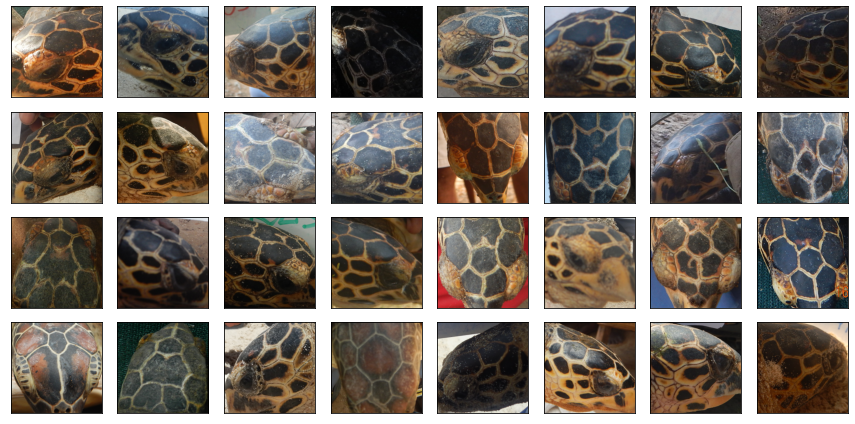

In [20]:
batch_images, _ = get_batch(batch_size=32)

_, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
axes = axes.flatten()
for img, ax in zip(list(batch_images), axes):
  ax.imshow(img)
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
plt.tight_layout()
plt.show()

Define our network: a ResNet50 model made available via the Haiku library. The output is of size `num_classes`:

In [21]:
@hk.without_apply_rng
@hk.transform_with_state
def resnet(x, is_training):
  return hk.nets.ResNet50(
      num_classes=num_classes, resnet_v2=True,
      bn_config={'decay_rate': 0.9})(x, is_training)

Next we define our loss and update functions.

The loss function computes the softmax cross entropy between the set of logits and labels and sums over the batch. We also add L2 regularisation on the model
parameters to help to alleviate overfitting.

The update function computes the gradients and updates the parameters using the `jax.grad` and `optax.apply_updates` utility functions.

In [22]:
@functools.partial(jax.value_and_grad, has_aux=True)
def loss_fn(params, state, inputs, labels):
  predicted, new_state = net.apply(params, state, inputs, is_training=True)
  predicted = jax.nn.log_softmax(predicted, axis=-1)
  labels_one_hot = jax.nn.one_hot(labels, num_classes=num_classes)
  loss = -(predicted * labels_one_hot).sum(axis=-1).mean()
  loss = loss + l2_regularisation(params) * 0.005
  return loss, new_state


@jax.jit
def update(params, state, opt_state, inputs, labels):
  (loss, new_state), grads = loss_fn(params, state, inputs, labels)
  updates, new_opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, new_state, new_opt_state, loss


def l2_regularisation(params):
  l2_norm = 0.
  for module_name, module_params in params.items():
    if 'batchnorm' not in module_name:
      l2_norm += sum(
          [jnp.sum(jnp.square(x)) for x in jax.tree_leaves(module_params)])
  return l2_norm

Now that our forward pass, loss function, and update function are defined, let's load in some pre-trained weights from a ResNet50 model trained on ImageNet:

In [24]:
!pip install dill
import pickle

checkpoint_url = urllib.parse.urljoin(BASE_URL,
                                      'resnet50_imagenet_checkpoint.pystate')
checkpoint = pickle.loads(requests.get(checkpoint_url).content)

# Get model params and state from the checkpoint.
pretrained_params = checkpoint['experiment_module']['params']
pretrained_state = checkpoint['experiment_module']['state']
pretrained_opt_state = checkpoint['experiment_module']['opt_state']

  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)
You should consider upgrading via the '/Users/tolga/.pyenv/versions/3.9.4/bin/python3.9 -m pip install --upgrade pip' command.


Most of the parameters of the pre-trained model are the same, except for the final layer:
- The pretrained ResNet50 model was trained to predict 1000 output classes
- Our current classification task has 101 output classes

This means we can use all of the pretrained parameters expect for those in the final layer, which will have to be learned from scratch.

We'll also need to update the optimiser state `opt_state` to reflect this change in final layer params.

In [25]:
import tree


def update_params(path, values, scale_factor=-1e-5):
  if path[-2:] == ('res_net50/~/logits', 'b'):
    return scale_factor * jax.random.normal(
        jax.random.PRNGKey(0), (num_classes,))
  elif path[-2:] == ('res_net50/~/logits', 'w'):
    return scale_factor * jax.random.normal(
        jax.random.PRNGKey(0), (values.shape[0], num_classes))
  else:
    return values


def update_opt_state(path, values):
  if path[-2:] == ('res_net50/~/logits', 'b'):
    return jnp.zeros((num_classes,))
  elif path[-2:] == ('res_net50/~/logits', 'w'):
    return jnp.zeros((values.shape[0], num_classes))
  else:
    return values


pretrained_params = tree.map_structure_with_path(update_params,
                                                 pretrained_params)
pretrained_opt_state = tree.map_structure_with_path(update_opt_state,
                                                    pretrained_opt_state)

Fine tune the model using the pretrained parameters to warm start the model (here, we are using the Adam optimiser from `optax`):

In [26]:
batch_size = 32
finetuned_losses = []
n_steps = 400
opt = optax.adam(1e-3)
opt_state = opt.init(pretrained_params)

net = resnet

for step in range(n_steps):
  batch_images, batch_labels = get_batch(batch_size)
  pretrained_params, pretrained_state, opt_state, loss = update(
      pretrained_params, pretrained_state, opt_state, batch_images,
      batch_labels)
  finetuned_losses.append(loss)
  if step % 50 == 0:
    print(f"Loss at step {step}: {loss:.3f}.", flush=True)

Loss at step 0: 35.520.
Loss at step 50: 12.698.
Loss at step 100: 7.296.
Loss at step 150: 5.985.
Loss at step 200: 6.072.
Loss at step 250: 5.400.
Loss at step 300: 4.917.
Loss at step 350: 5.209.


Plot the learning curve from this run:

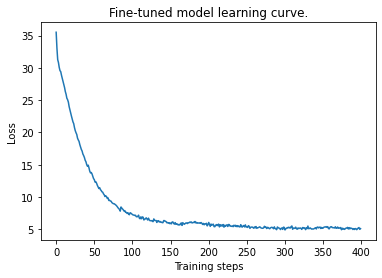

In [27]:
plt.plot(np.arange(len(finetuned_losses)), finetuned_losses)
plt.title("Fine-tuned model learning curve.")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

We can also train a simple CNN network from scratch:

In [28]:
@hk.without_apply_rng
@hk.transform_with_state
def simple_cnn(x, is_training):

  def conv_block(x, channels, kernel):
    x = hk.Conv2D(
        output_channels=channels,
        kernel_shape=kernel,
        stride=2,
        padding='SAME',
        with_bias=True)(
            x)
    x = jax.nn.relu(x)
    return x

  for channels, kernel in zip([8, 16], [3, 5]):
    x = conv_block(x, channels, kernel)
  x = hk.Flatten()(x)
  x = hk.Linear(128)(x)
  x = jax.nn.relu(x)
  x = hk.Linear(num_classes)(x)
  return x

In [29]:
# Initialise new network params, state, and optimiser from scratch.

net = simple_cnn

image_for_init, _ = get_batch(1)
params, state = net.init(jax.random.PRNGKey(1), image_for_init, True)
opt = optax.adam(1e-3)
opt_state = opt.init(params)

batch_size = 32
from_scratch_losses = []
n_steps = 1000

for step in range(n_steps):
  batch_images, batch_labels = get_batch(batch_size, rebalance=True)
  params, state, opt_state, loss = update(params, state, opt_state,
                                          batch_images, batch_labels)
  from_scratch_losses.append(loss)
  if step % 50 == 0:
    print(f"Loss at step {step}: {loss:.3f}.", flush=True)

Loss at step 0: 5.610.
Loss at step 50: 4.993.
Loss at step 100: 4.784.
Loss at step 150: 4.585.
Loss at step 200: 4.491.
Loss at step 250: 4.379.
Loss at step 300: 3.511.
Loss at step 350: 3.325.
Loss at step 400: 2.987.
Loss at step 450: 2.286.
Loss at step 500: 1.799.
Loss at step 550: 2.257.
Loss at step 600: 1.654.
Loss at step 650: 1.480.
Loss at step 700: 2.015.
Loss at step 750: 1.517.
Loss at step 800: 1.146.
Loss at step 850: 1.320.
Loss at step 900: 1.552.
Loss at step 950: 1.711.


Compare the learning curves from the two models:

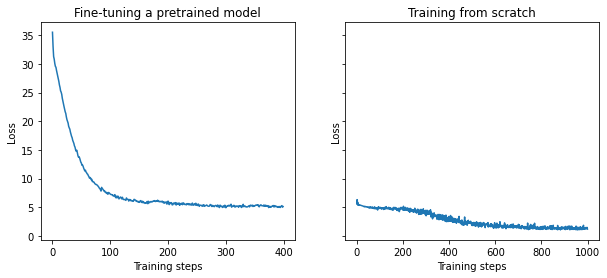

In [30]:
figure, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 4))

axes[0].plot(np.arange(len(finetuned_losses)), finetuned_losses)
axes[0].set_title("Fine-tuning a pretrained model")
axes[0].set(xlabel="Training steps", ylabel="Loss")
axes[1].plot(np.arange(len(from_scratch_losses)), from_scratch_losses)
axes[1].set_title("Training from scratch")
axes[1].set(xlabel="Training steps", ylabel="Loss")

plt.show()

### 7. Performing inference using trained models

We can make predictions on new examples using a trained model by passing the model parameters, state and (preprocessed) inputs to the `apply` function:

In [31]:
@jax.jit
def predict(params, state, inputs):
  """Forward pass of model with log softmaxed output."""
  predicted, _ = net.apply(params, state, inputs, is_training=False)
  return jax.nn.log_softmax(predicted, axis=-1)


def get_image_by_image_id(image_id):
  """Function to get a model-ready image given an image ID"""
  all_image_files = os.listdir(IMAGE_DIR)
  all_image_ids = [
      os.path.basename(file).split('.')[0] for file in all_image_files
  ]
  if image_id not in all_image_ids:
    raise ValueError(f'Could not find image with ID {image_id}')
  image_filepath = all_image_files[all_image_ids.index(image_id)]
  image = Image.open(os.path.join(IMAGE_DIR, image_filepath))
  image = crop_and_resize(image)
  return jnp.stack([jnp.asarray(image, dtype=jnp.float32) / 255.])

Now, given a new image ID like `ID_092X1NP4`, we can predict the corresponding most likely turtle ID:

In [32]:
logits = predict(params, state, get_image_by_image_id('ID_092X1NP4'))
logits = jax.device_get(logits)
predicted_turtle_id = label_lookup[int(np.argsort(logits)[0][-1])]

print(
    f'The top prediction for image ID "ID_092X1NP4" is "{predicted_turtle_id}".'
)

The top prediction for image ID "ID_092X1NP4" is "t_id_fxTQ5vHC".


## 8. Generating test set predictions

We can generate predictions for the entire test set by simply calling `predict` on each example. Let's first load the test images and apply the same cropping and resizing as before:

In [33]:
tqdm.tqdm._instances.clear()
test_image_files = [os.path.join(IMAGE_DIR, f) for f in os.listdir(IMAGE_DIR)
                    if f.split('.')[0] in test.image_id.values]
test_image_ids = [os.path.basename(f).split('.')[0] for f in test_image_files]
loaded_test_images = [crop_and_resize(Image.open(f)) for f in tqdm.tqdm(test_image_files)]

100%|█████████████████████████████████████████| 490/490 [00:09<00:00, 50.10it/s]


The following utilities will perform batch inference and format the results. For submission we need a csv with an `image_id` column, and separate columns for each of our top 5 predictions.

In [34]:
import collections

def batch_list(list_to_batch, batch_size):
  """Chunk up a list into batches, potentially with a smaller final batch."""
  return [list_to_batch[i:i + batch_size] for i in range(
      0, len(list_to_batch), batch_size)]

def predict_on_set(batched_image_ids,
                   batched_images,
                   params, state):
  """Returns top 5 predictions on batched images as a submission dataframe."""
  model_predictions = []

  for ids, images in zip(batched_image_ids, batched_images):
    # Stack images for batch inference.
    images = jnp.stack(
        [jnp.asarray(im, dtype=jnp.float32) / 255. for im in images])

    # Make predictions and sort logits to find top 5 predictions.
    logits = predict(params, state, images)
    logits = jax.device_get(logits)
    top_5_predictions = np.argsort(logits)[:, -5:][:, ::-1]

    # Format results.
    for image_id, predictions in zip(ids, top_5_predictions):
      row = {}
      predicted_turtle_ids = [label_lookup[label] for label in predictions]
      row['image_id'] = image_id
      for prediction_idx, prediction in enumerate(predicted_turtle_ids):
        row[f'prediction{prediction_idx + 1}'] = prediction
      model_predictions.append(row)

  return pd.DataFrame(model_predictions).set_index('image_id')

# Batch up test images and IDs.
eval_batch_size = 32
test_batched_images = batch_list(loaded_test_images, eval_batch_size)
test_batched_image_ids = batch_list(test_image_ids, eval_batch_size)

In [35]:
net = simple_cnn
predictions_from_scratch = predict_on_set(test_batched_image_ids,
                                          test_batched_images,
                                          params, state)
net = resnet
predictions_from_pretrained = predict_on_set(test_batched_image_ids,
                                             test_batched_images,
                                             pretrained_params,
                                             pretrained_state)

<a name="Submit"></a>
## 9. Submitting our predictions

Now our predictions are ready, we can save them to file and download them, ready to submit to Zindi:

In [ ]:
from google.colab import files

predictions_from_scratch.to_csv('submission.csv')
files.download('submission.csv')

### The evaluation metric: Mean Average Precision (`MAP@5`)

We are using Mean Average Precision at 5, where 5 refers to the number of predictions submitted for each turtle.


#### Precision @k (`P@k`)

- Defined as `true_positives_in_top_k_predictions / k `, this captures how many relevant items are present in the top `k` recommendations of your system.

- For example, let's assume the the prediction of one row is as follows:

  ```actual = "t_id_ROFhVsy2"```

  ``` predicted = ["t_id_ROFhVsy2", "t_id_UVQa4BMz", "t_id_a4VYrmyA", "new_turtle", "t_id_4ZfTUmwL"]```

  Then, for different values of `k`:

  `P@1  = 1/1 `

  `P@2 = 1/2 `

  `P@3 = 1/3`

  `P@4 = 1/4`

  `P@5 = 1/5`

  <br>

#### Average precision @ k (`AP@k`)
- Defined as the mean of `P@i` for `i=1, ..., K`.

<br>

#### Mean Average Precision @k (`MAP@K`)
- Defined as the mean of the `AP@K` for all the turtles.

- For our metric, `MAP@5`: sum `AP@5` for all the turtles and divide that value by the number of turtles

Here are functions that you can use to calculate the `AP@5` and `MAP@5` for a given label and list of predictions:

In [ ]:
def apk(actual, predicted, k=5):
  """Computes the average precision at k.

  Args:
    actual: The turtle ID to be predicted.
    predicted : A list of predicted turtle IDs (order does matter).
    k : The maximum number of predicted elements.

  Returns:
    The average precision at k.
  """
  if len(predicted) > k:
    predicted = predicted[:k]

  score = 0.0
  num_hits = 0.0

  for i, p in enumerate(predicted):
    if p == actual and p not in predicted[:i]:
      num_hits += 1.0
      score += num_hits / (i + 1.0)

  return score


def mapk(actual, predicted, k=5):
  """ Computes the mean average precision at k.

    The turtle ID at actual[i] will be used to score predicted[i][:k] so order
    matters throughout!

    actual: A list of the true turtle IDs to score against.
    predicted: A list of lists of predicted turtle IDs.
    k: The size of the window to score within.

    Returns:
      The mean average precision at k.
  """
  return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

In [ ]:
predictions = predictions_from_scratch[[
    "prediction1", "prediction2", "prediction3", "prediction4", "prediction5"
]]
y_predict = predictions.values.tolist()

# We don't actually know the true labels for the test set, so for the purposes
# of demonstration we just assume that all of the images in the test set are of
# a single turtle:
assumed_y = ["t_id_d6aYXtor"] * len(y_predict)

mapk_result = mapk(assumed_y, y_predict, k=5)
print("With made up test set labels, our mapk with k=5 is", mapk_result)

### Generalisability prize
Please note that there is an additional prize for generalisability: The likelihood of the approach and algorithm being able to generalise beyond the challenge dataset without frequent re-training, taking into account the approach and algorithm used.

<a name="Suggestions"></a>
## 8. Suggestions for improving the model

This tutorial provides a jumping off point for this task, but there are plenty of improvements you might consider making to the model presented in this colab. A few possible directions to explore:
- **Data-related**
  - Preprocessing the dataset in various ways - cropping, colour-correction, etc.
  - Augmenting the dataset - flipping, rotating, tinting, etc. the images to increase data size and potentially improve model generalisation
  - Making use of the extra images, listed in `extra_images.csv`, provided in the dataset
- **Model-related**
  - Outputting 'new_turtle' when the model is particularly uncertain
  - Trying different pre-trained models
  - Playing around with the model architecture
  - Trying model ensembling
  - Hyperparameter tuning
  - Other regularisation approaches

Thanks for reading, hope you enjoyed this tutorial and we're looking forward to seeing your entries!

<a name="Legal"></a>
## 9. License and Disclaimer

This is not an officially-supported Google product.

Copyright 2021 DeepMind Technologies Limited.

This notebook and code is licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at https://www.apache.org/licenses/LICENSE-2.0.

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.


**Model Parameters License**

The pre-trained model parameters are made available under the terms of the Creative Commons Attribution 4.0 International (CC BY 4.0) license. You can find details at: https://creativecommons.org/licenses/by/4.0/legalcode

**Data Set**

The data set of turtle images and associated labels have been provided by Zindi and Local Ocean Conservation.
